# New York University
## Applied Data Science 2016 Final Project
----
## Measuring household income under Redatam in CensusData
### *2. Merge Individual to Household Data*
----
**Project Description:** Lorem ipsum

**Members:**
- Felipe Gonzales
- Ilan Reinstein
- Fernando Melchor
- Nicolas Metallo

**Sources:**
- http://dlab-geo.github.io/geocoding-geopy/slides/index.html#2
- https://gist.github.com/rgdonohue/c4beedd3ca47d29aef01
- http://darribas.org/gds_scipy16/ipynb_md/07_spatial_clustering.html
- https://glenbambrick.com/2016/01/09/csv-to-shapefile-with-pyshp/
- http://statsmodels.sourceforge.net/devel/examples/generated/example_wls.html

# LIBRARIES

In [46]:
# helper functions
import getEPH
import categorize
import createVariables
import schoolYears
import make_dummy
import functionsForModels
# libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
np.random.seed(1024)
%matplotlib inline

In [47]:
getEPH.getEPHdbf('t310')

('Downloading', 't310')
file in place, creating CSV file
csv file cleanDataHousehold t310 .csv successfully created in folder data/
csv file cleanData t310 .csv successfully created in folder data/


# DATA HANDLING

In [48]:
data1 = pd.read_csv('data/cleanDatat310.csv')

In [49]:
data2 = categorize.categorize(data1)
data3 = schoolYears.schoolYears(data2)
data4 = createVariables.createVariables(data3)

# REGRESSION MODEL

### Predicted Income:

Using the model generated in the previous notebook (Model # 2 - Alternative) we create a new variable called **predicted income** with its output. The ultimate goal is to merge this data with household data.

In [50]:
jobsAndIncome = (data4.activity == 1) & (data4.P21 > 1) # we only consider people who are working and have income
headAndSpouse = (data4.familyRelation == 1)|(data4.familyRelation == 2) #
dataParaModelo = data4.copy().loc[jobsAndIncome,:]

In [51]:
variablesOfInterest = ['age',
                              'age2',
                              'female',
                              'education',
                              'education2']

In [52]:
model = functionsForModels.runModel(dataset = dataParaModelo, income = 'lnIncome', variables = variablesOfInterest)

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.287
Model:                            WLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     289.9
Date:                Sun, 11 Dec 2016   Prob (F-statistic):          2.70e-261
Time:                        22:15:31   Log-Likelihood:                -4091.5
No. Observations:                3608   AIC:                             8195.
Df Residuals:                    3602   BIC:                             8232.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.5938      0.138     40.537      0.0

In [53]:
X = sm.add_constant(dataParaModelo.copy().loc[:,variablesOfInterest].values)

In [54]:
dataParaModelo['predictedLnIncome'] = model.predict(X)

### Merge subset of individuals (with job and income) with total individuals

We create a merged dataset combining a subset of individuals (with job and income) with the total individuals. We then account for people with no income (kids or unemployed) and assign them a "0" income. The resulting dataset will succesfully match every individual with their household.

In [55]:
paraMerge = dataParaModelo.loc[:,['CODUSU', 'NRO_HOGAR', 'COMPONENTE','predictedLnIncome']]
paraMerge.head()

,CODUSU,NRO_HOGAR,COMPONENTE,predictedLnIncome
2,307861,1,1,7.478150
3,307861,1,2,7.991038
7,308278,1,1,8.485189
8,308278,1,2,7.750667
9,311937,1,1,8.336136


In [56]:
data = pd.merge(left = data4 , right = paraMerge, on = ['CODUSU', 'NRO_HOGAR', 'COMPONENTE'], how = 'left')

In [57]:
data.predictedLnIncome[data.predictedLnIncome.isnull()] = 0 

/Users/IlanReinstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### New variables for individuals

We create a set of new variables (re-arrangement of previous ones) set in a way we create will add value to our prediction

In [58]:
# Variables related to Occupation
data['job'] = (data.activity==1).astype(int)
data['noJob'] = (data.activity!=1).astype(int)
data['schoolAndJob'] = data.job * data.education

In [59]:
cantidadActivos = data.job.groupby(by=data['id']).sum() # Number of people working in the household
cantidadInactivos = data.noJob.groupby(by=data['id']).sum() # Number of people not working in the household
schoolAndJob = data.schoolAndJob.groupby(by=data['id']).sum() # Sum of total schooling years in the household

In [60]:
dfJobsAndEduc = pd.merge(left = schoolAndJob.to_frame() ,
                         right = cantidadInactivos.to_frame(),
                         left_index = True,
                         right_index = True)
dfJobsAndEduc = pd.merge(left = dfJobsAndEduc ,
                         right = cantidadActivos.to_frame(),
                         left_index = True,
                         right_index = True)

### Create Pivot Dataset

We create a pivot dataset in order to merge it later with the household dataset. With this we will have all individual information relative to a particular household.

In [61]:
cleanData = data.copy().loc[(headAndSpouse),
                              ['id',
                               'AGLOMERADO',
                            'familyRelation',
                              'age',
                              'age2',
                              'female',
                              'education',
                              'education2',
                              'primary',
                              'secondary',
                              'university',
                              'P21',
                              'P47T',
                              'lnIncome',
                               u'lnIncomeT',
                              'predictedLnIncome',
                              'job',
                              'DECCFR',
                               'DECIFR',
                               'maritalStatus',
                               'reading',
                               'placeOfBirth',
                              ]]

In [62]:
cleanData.head()

,id,AGLOMERADO,familyRelation,age,age2,female,education,education2,primary,secondary,...,P47T,lnIncome,lnIncomeT,predictedLnIncome,job,DECCFR,DECIFR,maritalStatus,reading,placeOfBirth
0,3024681,32,1,20,400,1,13.0,169.0,7.0,5.0,...,2000,0.000000,7.600902,0.000000,0,8,6,5,1,1
2,3078611,32,1,42,1764,0,7.0,49.0,7.0,0.0,...,3000,8.006368,8.006368,7.478150,1,6,8,2,1,2
3,3078611,32,2,44,1936,1,17.0,289.0,7.0,5.0,...,2800,7.937375,7.937375,7.991038,1,6,8,2,1,2
6,3087621,32,1,68,4624,1,17.0,289.0,7.0,5.0,...,3200,0.000000,8.070906,0.000000,0,9,5,4,1,3
7,3082781,32,1,38,1444,0,17.0,289.0,7.0,5.0,...,6000,8.517193,8.699515,8.485189,1,10,10,2,1,1


In [63]:
pivot = cleanData.pivot(index='id', columns='familyRelation')
pivot.head()

AGLOMERADO         age          age2        female       \
familyRelation          1     2     1     2       1      2      1    2   
id                                                                       
1250971              33.0   NaN  57.0   NaN  3249.0    NaN    1.0  NaN   
1253451              32.0   NaN  66.0   NaN  4356.0    NaN    1.0  NaN   
1254461              32.0   NaN  79.0   NaN  6241.0    NaN    1.0  NaN   
1256691              33.0   NaN  61.0   NaN  3721.0    NaN    0.0  NaN   
1256892              32.0  32.0  31.0  23.0   961.0  529.0    0.0  1.0   

               education       ...  DECCFR      DECIFR      maritalStatus  \
familyRelation         1     2 ...       1    2      1    2             1   
id                             ...                                          
1250971             14.0   NaN ...     8.0  NaN    9.0  NaN           4.0   
1253451              7.0   NaN ...     8.0  NaN    6.0  NaN           3.0   
1254461             12.0   NaN ...     7.0  NaN    2.0  NaN           4.0   
1256691              7.0   NaN ...     8.0  NaN    9.0  NaN           4.0   
1256892             12.0  12.0 ...     5.0  5.0    5.0  5.0           1.0   

                    reading      placeOfBirth       
familyRelation    2       1    2            1    2  
id                                                  
1250971         NaN     1.0  NaN          1.0  NaN  
1253451         NaN     1.0  NaN          1.0  NaN  
1254461         NaN     1.0  NaN          1.0  NaN  
1256691         NaN     1.0  NaN          1.0  NaN  
1256892         1.0     1.0  1.0          4.0  4.0  

[5 rows x 40 columns]

### Create Intermediate Dataset

We save our dataset into a csv file in order to eliminate the double index, and then after some data handling we export our final dataset.

In [64]:
pivot.to_csv('data/pivotInd.csv')

In [65]:
dataN = pd.read_csv('data/pivotInd.csv', names = ['id','AGLO1','AGLO2','headAge','spouseAge','headAge2','spouseAge2',
                                                  'headFemale','spouseFemale','headEduc','spouseEduc',
                                                  'headEduc2','spouseEduc2','headPrimary','spousePrimary',
                                                  'headSecondary','spouseSecondary','headUniversity','spouseUniversity',
                                                  'headP21','spouseP21','headP47T','spouseP47T',
                                                  'headLnIncome','spouseLnIncome','headLnIncomeT','spouseLnIncomeT',
                                                  'headPredictedLnIncome','spousePredictedLnIncome','headJob','spouseJob',
                                                  'headDECCFR','spouseDECCFR','headDECIFR','spouseDECIFR',
                                                  'headMaritalStatus','spouseMaritalStatus',
                                                  'headReading','spouseReading','headPlaceOfBirth','spouseplaceOfBirth',
                                                 ],skiprows = 3)

In [66]:
dfJobsAndEduc['id'] = dfJobsAndEduc.index
dfJobsAndEduc['id'] = dfJobsAndEduc['id'].astype(int)
dataFinalCSV = pd.merge(left = dfJobsAndEduc ,
                         right = dataN,
                         left_on = 'id',
                         right_on = 'id')

In [67]:
dataFinalCSV.to_csv('data/pivotInd.csv',index=False)
dataFinalCSV.head()

,schoolAndJob,noJob,job,id,AGLO1,AGLO2,headAge,spouseAge,headAge2,spouseAge2,...,headDECCFR,spouseDECCFR,headDECIFR,spouseDECIFR,headMaritalStatus,spouseMaritalStatus,headReading,spouseReading,headPlaceOfBirth,spouseplaceOfBirth
0,40.0,1,3,1250971,33.0,NaN,57.0,NaN,3249.0,NaN,...,8.0,NaN,9.0,NaN,4.0,NaN,1.0,NaN,1.0,NaN
1,12.0,1,1,1253451,32.0,NaN,66.0,NaN,4356.0,NaN,...,8.0,NaN,6.0,NaN,3.0,NaN,1.0,NaN,1.0,NaN
2,0.0,1,0,1254461,32.0,NaN,79.0,NaN,6241.0,NaN,...,7.0,NaN,2.0,NaN,4.0,NaN,1.0,NaN,1.0,NaN
3,14.0,2,2,1256691,33.0,NaN,61.0,NaN,3721.0,NaN,...,8.0,NaN,9.0,NaN,4.0,NaN,1.0,NaN,1.0,NaN
4,24.0,1,2,1256892,32.0,32.0,31.0,23.0,961.0,529.0,...,5.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,4.0,4.0


# GET HOUSEHOLD DATA

** Variables description: **
- HomeType
- FloorMaterial
- RoofMaterial
- RoofCoat
- Water
- WaterType
- Toilet
- ToletLocation
- ToiletType

In [68]:
getEPH.getEPHdbf('t310')
hog = pd.read_csv('data/cleanDataHouseholdt310.csv')
print hog.shape
hog.head()

('Downloading', 't310')
file in place, creating CSV file
csv file cleanDataHousehold t310 .csv successfully created in folder data/
csv file cleanData t310 .csv successfully created in folder data/
(2703, 50)


,CODUSU,NRO_HOGAR,REGION,PONDERA,HomeType,HomeTypeesp,RoomsNumber,FloorMaterial,FloorMaterialesp,RoofMaterial,...,DomesticService3,DomesticService4,DomesticService5,DomesticService6,TotalFamilyIncome,TotalFamilyIncomeDec,TotalFamilyIncomeDecReg,PerCapInc,PerCapIncDec,PerCapIncDecReg
0,302468,1,1,1287,2,NaN,2,1,NaN,9,...,2,0,0,0,4000.0,6,6,2000.0,8,8
1,307861,1,1,1674,2,NaN,2,1,NaN,1,...,98,0,0,0,5800.0,8,8,1450.0,6,6
2,308762,1,1,1522,2,NaN,4,1,NaN,9,...,98,0,0,0,3200.0,5,5,3200.0,9,9
3,308278,1,1,1320,2,NaN,3,1,NaN,9,...,96,0,0,0,10000.0,10,10,5000.0,10,10
4,311937,1,1,1281,2,NaN,4,1,NaN,1,...,96,0,0,0,11000.0,10,10,2750.0,9,9


# DATA CLEANING

In [69]:
def remove9(df,variables):
    for var in variables:
        df[var].replace(to_replace=[9], value=[np.nan] , inplace=True, axis=None)

def remove0(df,variables):
    for var in variables:
        df[var].replace(to_replace=[0], value=[np.nan] , inplace=True, axis=None)

def remove99(df,variables):
    for var in variables:
        df[var].replace(to_replace=[99], value=[np.nan] , inplace=True, axis=None)

In [70]:
hog2 = hog.copy()

remove9(df = hog2, variables = ['FloorMaterial','RoofMaterial','RoofCoat','Water','WaterType','Toilet','ToiletLocation',
                               'ToiletType','Sewer','DumpSites','Flooding','EmergencyLoc','CookingCombustible',
                               'BathroomUse'])
remove0(df = hog2, variables = ['FloorMaterial','RoofMaterial','RoofCoat','Water','WaterType','Toilet','ToiletLocation',
                               'ToiletType','Sewer','DumpSites','Flooding','EmergencyLoc','Ownership','CookingCombustible',
                               'BathroomUse'])
remove99(df = hog2, variables = ['Ownership'])

### Ordinal Order Transformation

In order to have positive coefficients we changed the order in which ordinal variables were displayed. We only do this for 'CookingCombustible' (which shows what combustible is used in the household) and for the others we use dummy variables.

1.0    2109
2.0     552
4.0      11
3.0       3
Name: CookingCombustible, dtype: int64


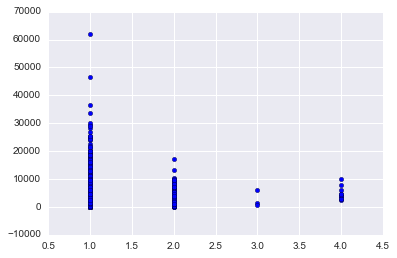

In [71]:
variables = ['CookingCombustible']
for var in variables:
    print hog2[var].value_counts()
    plt.scatter(hog2[var], hog2.TotalHouseHoldIncome)
    plt.show()

In [72]:
hog2['CookingRec'] = np.nan
hog2['CookingRec'][hog2.CookingCombustible == 4] = 1
hog2['CookingRec'][hog2.CookingCombustible == 3] = 1
hog2['CookingRec'][hog2.CookingCombustible == 2] = 2
hog2['CookingRec'][hog2.CookingCombustible == 1] = 3

/Users/IlanReinstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/IlanReinstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/IlanReinstein/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/IlanReinstein/anaconda/lib/python

3.0    2109
2.0     552
1.0      14
Name: CookingRec, dtype: int64


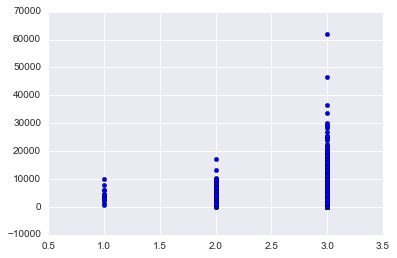

In [73]:
variables = ['CookingRec']
for var in variables:
    print hog2[var].value_counts()
    plt.scatter(hog2[var], hog2.TotalHouseHoldIncome)
    plt.show()

In [74]:
hog2['WaterRec'] = (hog2.Water == 1).astype(int)

hog2['OwnershipRec'] = ((hog2.Ownership == 1) | (hog2.Ownership == 3)).astype(int)
hog2['Hacinamiento'] = hog2.HouseMembers * 1.0 / hog2.SleepingRooms
hog2['id'] =  (hog2.CODUSU.astype(str) + hog2.NRO_HOGAR.astype(str))

hog2['TotalHouseHoldIncome'].replace(to_replace=[0], value=[1] , inplace=True, axis=None)
hog2['lnHouseIncome'] = np.log(hog2['TotalHouseHoldIncome'])
sinCuartosParaDormir = (hog2.SleepingRooms == 0)

In [75]:
hogReducida = hog2.copy().drop(['CODUSU','NRO_HOGAR','REGION','HomeTypeesp','FloorMaterialesp',
                              'WaterTypeesp','Ownershipesp','CookingCombustibleesp','DomesticService1', 
                               'DomesticService2', 'DomesticService3','DomesticService4', 'DomesticService5',
                               'DomesticService6'],axis = 1)

# LOAD INDIVIDUAL DATA

In [76]:
# Load data previously exported

ind = pd.read_csv('data/pivotInd.csv')
ind['id'] = ind['id'].astype(str)

ind.drop(['AGLO2'],axis =1,inplace=True)
ind['sumPredicted'] = ind.headPredictedLnIncome + ind.spousePredictedLnIncome

# MERGE INDIVIDUAL WITH HOUSEHOLD

In [77]:
hogReducida = hogReducida.copy().loc[~sinCuartosParaDormir,:]

In [78]:
# check before merge

print 'filas hog:',hogReducida.shape[0]
print 'filas ind:',ind.shape[0]
print 'cantidad de ind en hog:', sum(ind['id'].sort_values().isin(hogReducida['id'].sort_values()))

filas hog: 2675
filas ind: 2703
cantidad de ind en hog: 2675


In [79]:
dataUnida = pd.merge(left=hogReducida, right=ind, on='id',how='left')

In [80]:
dataUnida.to_csv('data/dataFinalParaModelo.csv',index=False)